In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.ensemble import IsolationForest
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest


# Data Visualisation and EDA

In [25]:
data = pd.read_csv(
    '/Users/rajdipingale/Downloads/household_power_consumption.csv', 
    sep=';', 
    parse_dates={'datetime': ['Date', 'Time']}, 
    infer_datetime_format=True, 
    low_memory=False, 
    na_values=['nan', '?']
)

# Drop rows with missing values
data.dropna(inplace=True)

# Convert to appropriate data types
data['Global_active_power'] = data['Global_active_power'].astype(float)
data['Global_reactive_power'] = data['Global_reactive_power'].astype(float)
data['Voltage'] = data['Voltage'].astype(float)
data['Global_intensity'] = data['Global_intensity'].astype(float)
data['Sub_metering_1'] = data['Sub_metering_1'].astype(float)
data['Sub_metering_2'] = data['Sub_metering_2'].astype(float)
data['Sub_metering_3'] = data['Sub_metering_3'].astype(float)

In [26]:
data.head(10)

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


In [27]:
# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())


       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00   

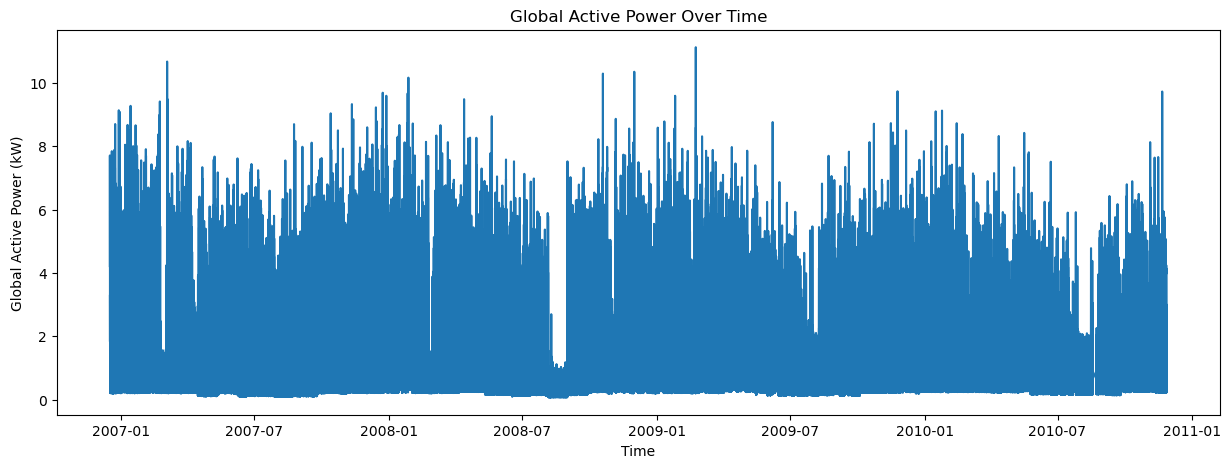

In [28]:
# Plot Global Active Power over time
plt.figure(figsize=(15, 5))
plt.plot(data['datetime'], data['Global_active_power'])
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.show()


Global_active_power      0
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64


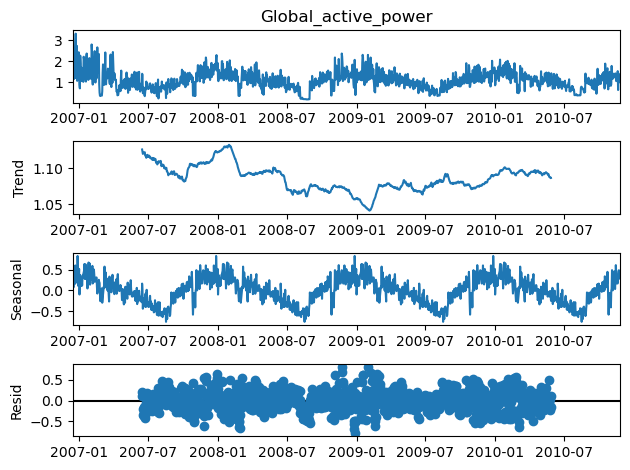

In [36]:

# Fill missing values with interpolation in the original data
data['Global_active_power'].interpolate(method='linear', inplace=True)

# Resample data to daily means
daily_data = data.resample('D', on='datetime').mean()

# Fill any remaining missing values in the daily resampled data
daily_data['Global_active_power'].interpolate(method='linear', inplace=True)

# Check for any remaining missing values
print(daily_data.isnull().sum())

# Decompose the time series
decomposition = seasonal_decompose(daily_data['Global_active_power'], model='additive', period=365)
decomposition.plot()
plt.show()


 Correlation Analysis


/var/folders/jw/b828mxp17cg561jtj9ps_vr80000gn/T/ipykernel_37688/1178149108.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


                       Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.247017 -0.399762   
Global_reactive_power             0.247017               1.000000 -0.112246   
Voltage                          -0.399762              -0.112246  1.000000   
Global_intensity                  0.998889               0.266120 -0.411363   
Sub_metering_1                    0.484401               0.123111 -0.195976   
Sub_metering_2                    0.434569               0.139231 -0.167405   
Sub_metering_3                    0.638555               0.089617 -0.268172   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power            0.998889        0.484401        0.434569   
Global_reactive_power          0.266120        0.123111        0.139231   
Voltage                       -0.411363       -0.195976       -0.167405   
Global_intensity               1.000000        0.489298        0.44

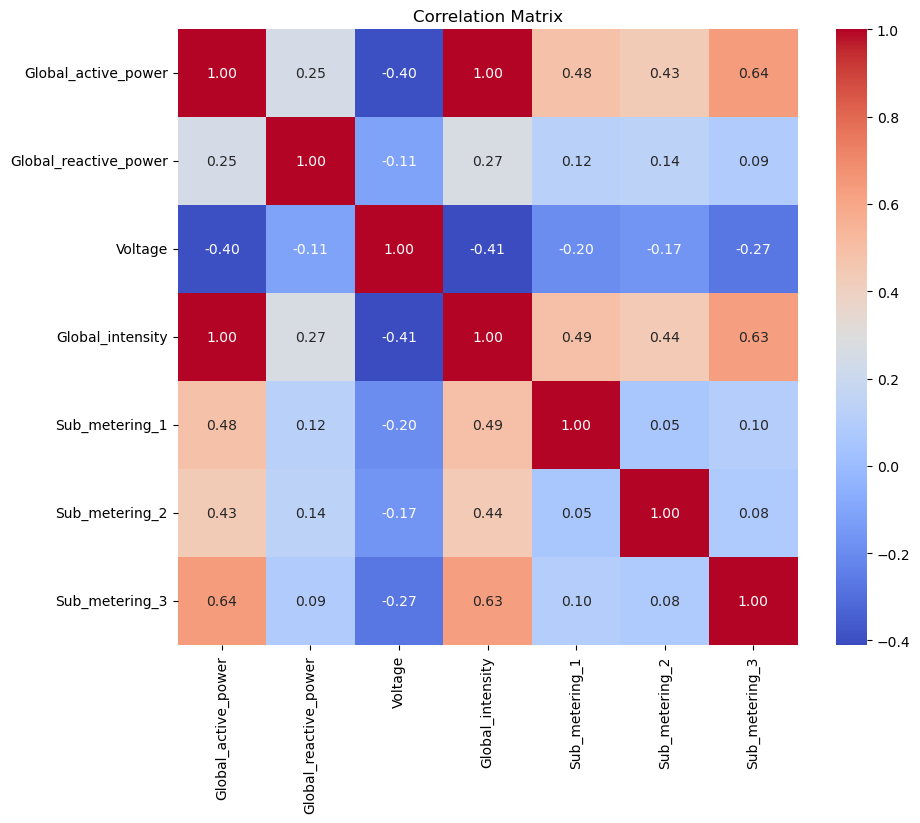

In [37]:
# Correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Distribution Analysis


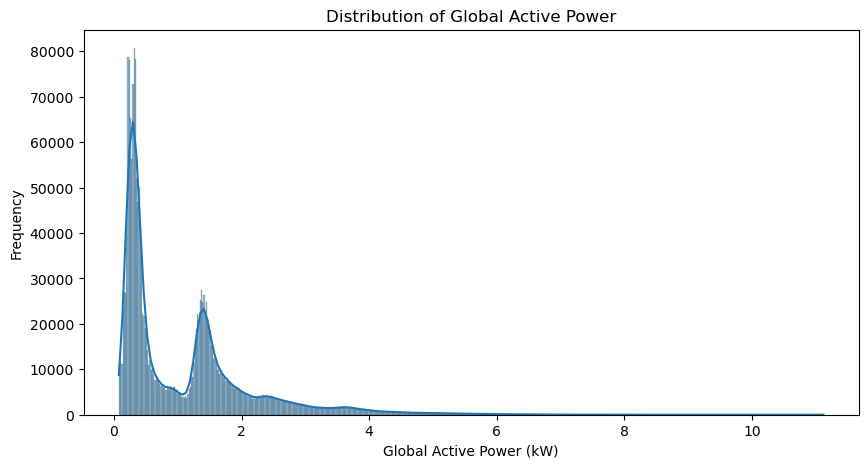

In [38]:
# Histogram of Global Active Power
plt.figure(figsize=(10, 5))
sns.histplot(data['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.show()

/Users/rajdipingale/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


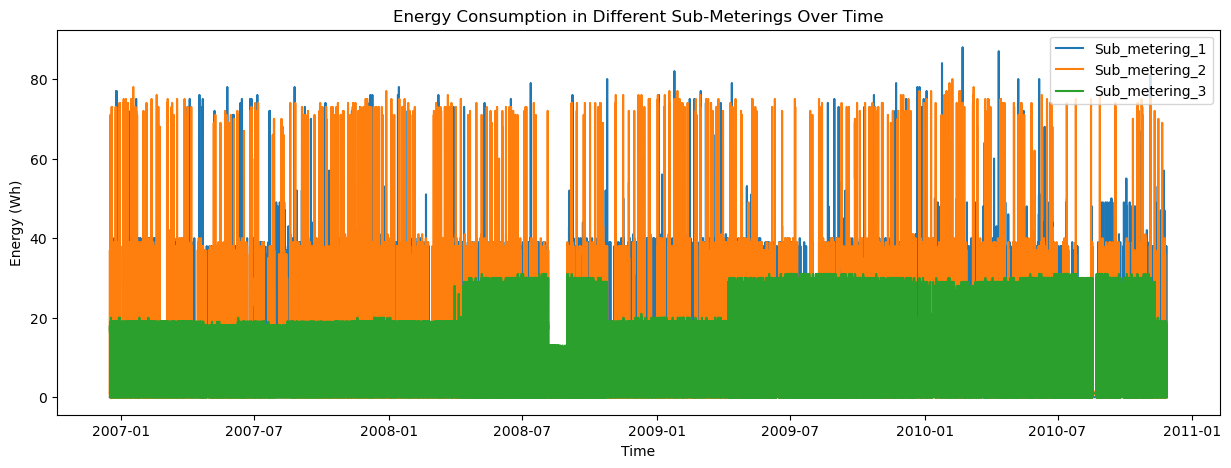

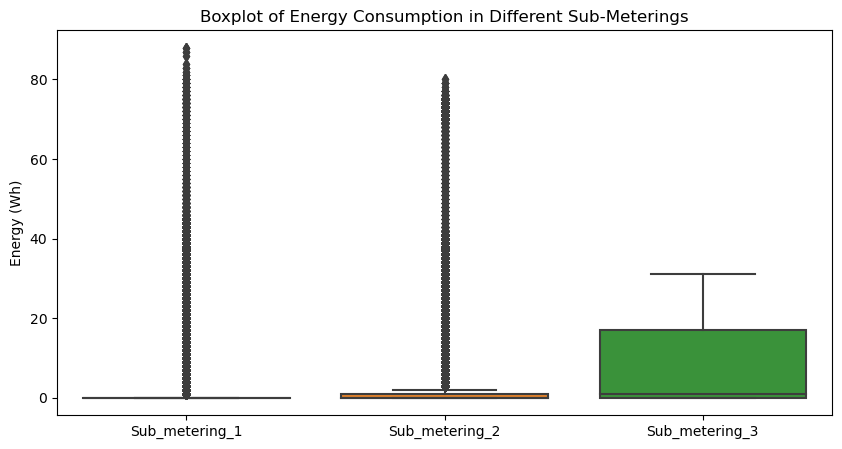

In [39]:
# Time series plot for sub-meterings
plt.figure(figsize=(15, 5))
plt.plot(data['datetime'], data['Sub_metering_1'], label='Sub_metering_1')
plt.plot(data['datetime'], data['Sub_metering_2'], label='Sub_metering_2')
plt.plot(data['datetime'], data['Sub_metering_3'], label='Sub_metering_3')
plt.legend()
plt.title('Energy Consumption in Different Sub-Meterings Over Time')
plt.xlabel('Time')
plt.ylabel('Energy (Wh)')
plt.show()

# Boxplot for sub-meterings
plt.figure(figsize=(10, 5))
sns.boxplot(data=[data['Sub_metering_1'], data['Sub_metering_2'], data['Sub_metering_3']])
plt.xticks([0, 1, 2], ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])
plt.title('Boxplot of Energy Consumption in Different Sub-Meterings')
plt.ylabel('Energy (Wh)')
plt.show()


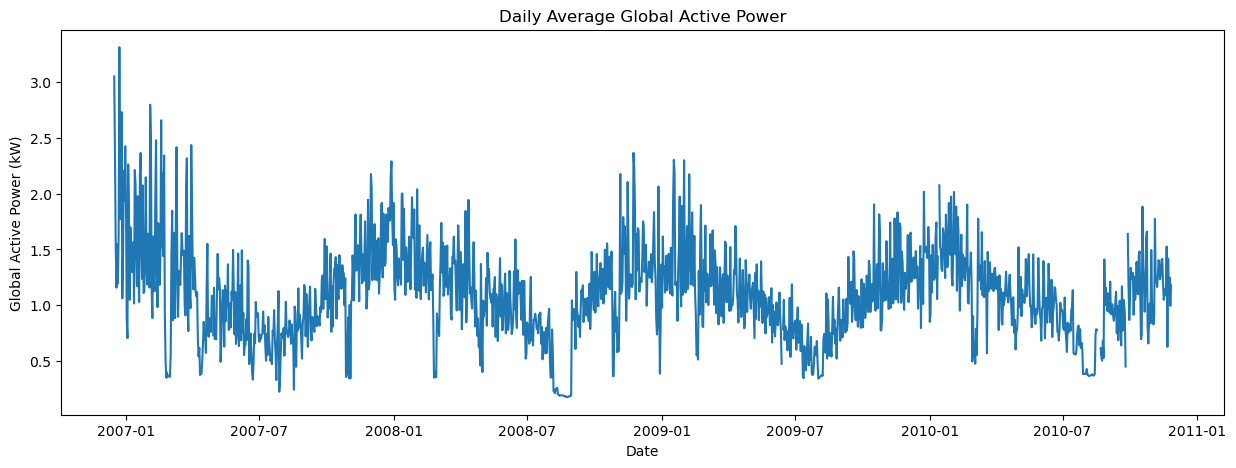

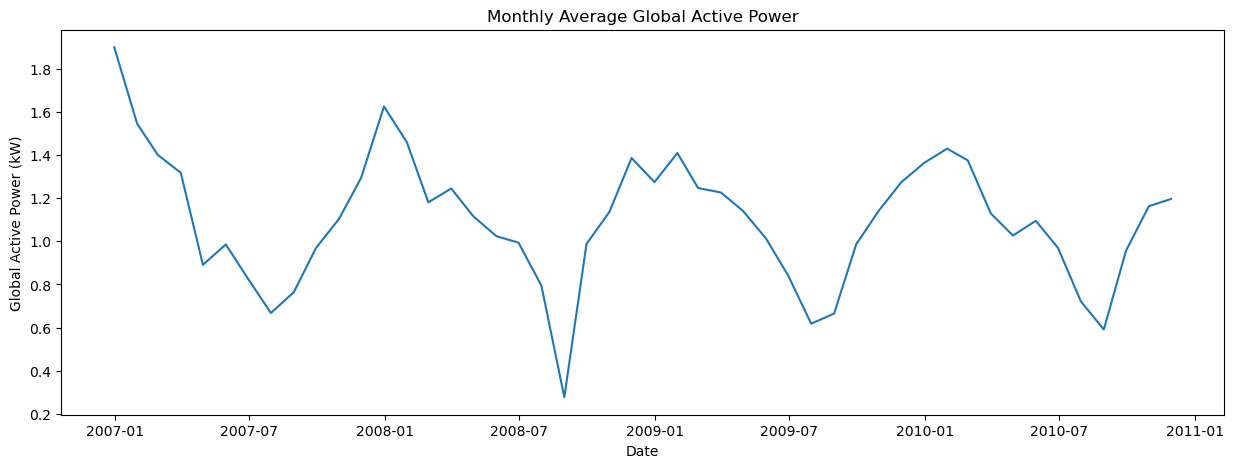

In [40]:
# Daily aggregation
daily_data = data.resample('D', on='datetime').mean()

plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['Global_active_power'])
plt.title('Daily Average Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()

# Monthly aggregation
monthly_data = data.resample('M', on='datetime').mean()

plt.figure(figsize=(15, 5))
plt.plot(monthly_data.index, monthly_data['Global_active_power'])
plt.title('Monthly Average Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.show()


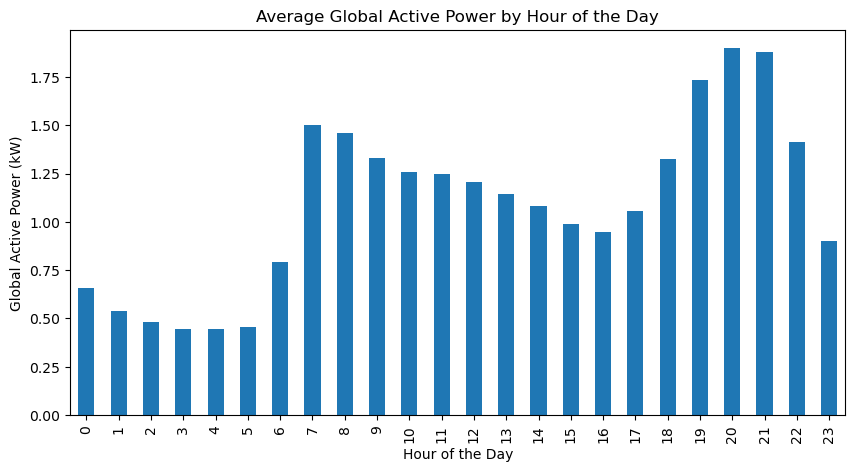

In [41]:
# Extract hour from datetime
data['hour'] = data['datetime'].dt.hour

# Group by hour to find average power consumption
hourly_data = data.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(10, 5))
hourly_data.plot(kind='bar')
plt.title('Average Global Active Power by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Global Active Power (kW)')
plt.show()


# PART A(LSTM)

In [16]:

# Select relevant columns
data = data[['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

# Normalize the data
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(data.drop('datetime', axis=1))

# Separate target and scale it separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(data[['Global_active_power']])

# Combine scaled features and target
scaled_data = np.hstack((scaled_target, scaled_features[:, 1:]))

# Prepare the training and test datasets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = target_scaler.inverse_transform(predictions)

# Output some predictions for verification
print(predictions[:10])

# Function to predict consumption for a new date
def predict_new_date(new_date_data, look_back=10):
    # Normalize the new data
    scaled_new_data = feature_scaler.transform(new_date_data)

    # Prepare the data for prediction
    X_new = []
    X_new.append(scaled_new_data)

    # Reshape input to be [samples, time steps, features]
    X_new = np.array(X_new)
    X_new = np.reshape(X_new, (X_new.shape[0], look_back, X_new.shape[2]))

    # Make predictions
    new_predictions = model.predict(X_new)

    # Inverse transform the predictions
    new_predictions = target_scaler.inverse_transform(new_predictions)
    return new_predictions

# Example usage for predicting a new date
new_date_data = data.tail(look_back).drop('datetime', axis=1).values
new_predictions = predict_new_date(new_date_data)
print("Predicted consumption for the next Timestamp:")
print(new_predictions)


/Users/rajdipingale/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82012/82012 ━━━━━━━━━━━━━━━━━━━━ 145s 2ms/step - loss: 0.0123
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[1.081412 ]
 [1.0814139]
 [1.0814083]
 [1.0814104]
 [1.0814133]
 [1.0814153]
 [1.0814162]
 [1.081411 ]
 [1.0814128]
 [1.0814084]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted consumption for the new date:
[[1.0814176]]


/Users/rajdipingale/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Part B (Matrix Factorisation)

In [17]:

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.drop('datetime', axis=1))

# Construct the feature-target matrix
matrix = pd.DataFrame(scaled_data, columns=['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])

# Apply SVD
svd = TruncatedSVD(n_components=4)  
U = svd.fit_transform(matrix)
Sigma = np.diag(svd.singular_values_)
Vt = svd.components_

# Reconstruct the matrix
reconstructed_matrix = np.dot(U, np.dot(Sigma, Vt))

# Compare the original and reconstructed matrix
print("Original Matrix:")
print(matrix.head())

print("Reconstructed Matrix:")
print(pd.DataFrame(reconstructed_matrix, columns=matrix.columns).head())

# Define a function to recommend sub-metering actions
def recommend_sub_metering_svd(matrix, U, Sigma, Vt, look_back=60):
    last_observation = matrix.tail(look_back).values
    baseline_consumption = last_observation[:, 0].mean()  

    recommendations = []

    for i, sub_meter in enumerate(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']):
        modified_last_observation = last_observation.copy()
        modified_last_observation[:, 4 + i] = 0  

        # Reconstruct the modified matrix
        modified_reconstructed_matrix = np.dot(U, np.dot(Sigma, Vt))
        modified_consumption = modified_reconstructed_matrix[:, 0].mean()  

        if modified_consumption < baseline_consumption:
            recommendations.append((sub_meter, 'off'))
        else:
            recommendations.append((sub_meter, 'on'))

    return recommendations

# Get recommendations
recommendations_svd = recommend_sub_metering_svd(matrix, U, Sigma, Vt)
print("Recommendations for sub-meterings (SVD-based):", recommendations_svd)


Original Matrix:
   Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
0             0.145572               0.135593  0.597527          0.136150   
1             0.061195               0.000000  0.588693          0.075117   
2             0.070593               0.271186  0.537809          0.075117   
3             0.007728               0.000000  0.460777          0.009390   
4             0.014829               0.000000  0.650883          0.014085   

   Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             0.0        0.012987        0.032258  
1             0.0        0.000000        0.000000  
2             0.0        0.012987        0.000000  
3             0.0        0.000000        0.000000  
4             0.0        0.000000        0.000000  
Reconstructed Matrix:
   Global_active_power  Global_reactive_power     Voltage  Global_intensity  \
0            20.803702              22.272848  116.042857         20.445669   
1            15.120944      

# Part C  (Isolation Forest)

In [5]:

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(scaled_data)

# Predict anomalies
anomalies = model.predict(scaled_data)
anomaly_indices = np.where(anomalies == -1)[0]

# Output the anomalies
anomaly_data = data.iloc[anomaly_indices]
print(anomaly_data)


                  datetime  Global_active_power  Global_reactive_power  \
1      2006-12-16 17:25:00                5.360                  0.436   
2      2006-12-16 17:26:00                5.374                  0.498   
3      2006-12-16 17:27:00                5.388                  0.502   
10     2006-12-16 17:34:00                4.448                  0.498   
11     2006-12-16 17:35:00                5.412                  0.470   
...                    ...                  ...                    ...   
414369 2007-09-30 11:33:00                3.858                  0.240   
414373 2007-09-30 11:37:00                3.858                  0.240   
414374 2007-09-30 11:38:00                3.854                  0.240   
414375 2007-09-30 11:39:00                3.864                  0.242   
414379 2007-09-30 11:43:00                3.738                  0.242   

        Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
1        233.63              23.0         

In [6]:

# Function to preprocess new data
def preprocess_new_data(new_data, scaler, feature_columns):
    new_data = new_data.dropna()
    scaled_new_data = scaler.transform(new_data[feature_columns])
    return scaled_new_data

# Function to predict if new data points are anomalies
def predict_anomalies(new_data, model, scaler, feature_columns):
    scaled_new_data = preprocess_new_data(new_data, scaler, feature_columns)
    predictions = model.predict(scaled_new_data)
    return predictions

# Example new data
new_data = pd.DataFrame({
    'Global_active_power': [2.5, 0.5, 1.0],
    'Global_reactive_power': [0.1, 0.2, 0.1],
    'Voltage': [230.0, 231.0, 229.0],
    'Global_intensity': [10.0, 5.0, 7.0],
    'Sub_metering_1': [0.0, 0.0, 1.0],
    'Sub_metering_2': [1.0, 2.0, 0.0],
    'Sub_metering_3': [5.0, 3.0, 4.0]
})

# Predict if the new data points are anomalies
new_anomalies = predict_anomalies(new_data, model, scaler, features)
print("New Data Predictions:")
print(new_anomalies)

New Data Predictions:
[1 1 1]
